In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
from pprint import pprint as pp
import scipy.stats
import seaborn as sns
import copy


In [3]:
datapath = "~/teigen_data/output_rows.csv"
paper_dpi = 600

In [4]:
available_radius_methods = [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder volume + sphere error",
    "cylinder volume + sphere error + man",
    "cylinder volume + sphere error + join error",
    "cylinder surface", 
    "cylinder surface + sphere error",
    "cylinder surface + sphere error + join error",
    "cylinder surface + sphere error + join error man",
    "best",
    
]

In [5]:
plotkw ={
    "figsize": [9, 6], 
    "fontsize": 14, 
}
plot_title_size = 40
plot_linewidth = 3
plot_title_size = None
plot_linewidth = None

plot_boxprops = {
    "linewidth": plot_linewidth
}
boxplotkw = {
    "figsize": [9, 6], 
    "fontsize": 14, 
    "boxprops": plot_boxprops,
    "medianprops": plot_boxprops,
    "whiskerprops": plot_boxprops,
    "capprops": plot_boxprops,
    
}

figurekw = {
    "figsize": [9, 6]
}

plotkw = {}
boxplotkw = {}
figurekw = {}


In [6]:

run_label_key = "run_label"

# Read write data

In [7]:
                

def read_data(datapath):
    df = pd.read_csv(op.expanduser(datapath))
    # remove duplicates
    ks = copy.copy(list(df.keys()))
#     ks.remove("processing_info datetime")
    ks = list_filter(ks, notstartswith="processing_info")
    df = df.drop_duplicates(ks)
    df["volume [mm^3]"] = df["measurement volume [mm^3]"]
    df["numeric volume [mm^3]"] = df["measurement numeric volume [mm^3]"]
    df["surface [mm^2]"] = df["measurement surface [mm^2]"]
    df["numeric surface [mm^2]"] = df["measurement numeric surface [mm^2]"]
    
    df["surface difference [mm^2]"] = df["numeric surface [mm^2]"] - df["surface [mm^2]"]
    df["surface difference [-]"] = df["surface difference [mm^2]"] / df["surface [mm^2]"]
    df["surface difference [%]"] = df["surface difference [mm^2]"] / df["surface [mm^2]"] * 100
    df["volume difference [mm^3]"] = df["numeric volume [mm^3]"] - df["volume [mm^3]"]
    df["volume difference [-]"] = df["volume difference [mm^3]"] / df["volume [mm^3]"]
    df["volume difference [%]"] = df["volume difference [mm^3]"] / df["volume [mm^3]"] * 100
    df["surface error [mm^2]"] = np.abs(df["surface difference [mm^2]"])
    df["surface error [-]"] = np.abs(df["surface difference [-]"])
    df["surface error [%]"] = np.abs(df["surface difference [%]"])
    df["volume error [mm^3]"] = np.abs(df["volume difference [mm^3]"])
    df["volume error [-]"] = np.abs(df["volume difference [-]"])
    df["volume error [%]"] = np.abs(df["volume difference [%]"])
    
    df["measurement_resolution"] = df["config postprocessing measurement_resolution"]
    df["length_distribution_mean"] = df["config generators Unconnected tubes length_distribution_mean"]
    df["radius_distribution_mean"] = df["config generators Unconnected tubes radius_distribution_mean"]
    df["element_number"] = df["config generators Unconnected tubes element_number"]
    df["element number"] = df["element_number"]
    df["measurement resolution"] = df["measurement_resolution"]
    df["step 1 time [s]"] = df["processing_info step1_total_time_s"]
    df["step 2 time [s]"] = df["processing_info step2_total_time_s"]
    df["total time [s]"] = df["step 1 time [s]"] + df["step 2 time [s]"]
    df["radius method"] = df["config measurement polygon_radius_selection_method"]
    
    
    return df
# read_data(datapath)

def savefig(fn, dpi=None, dataframe=None):
    if dpi is None:
        dpi = paper_dpi
    plt.savefig(fn + ".pdf", bbox_inches='tight')
    plt.savefig(fn + ".png", bbox_inches='tight', dpi=dpi)
    if dataframe is not None:
        dataframe.to_csv(fn + ".csv", index=False)
        dataframe.to_excel(fn + ".xls")
        
        desc = dataframe.describe()
        desc.to_csv(fn + "_describe.csv", index=False)
        desc.to_excel(fn + "_describe.xls")
        
        
def append_dataframe_to_csv(df, filename):
    import pandas as pd 
    filename = op.expanduser(filename)
    if op.exists(filename):
        dfin = pd.read_csv(filename)
        df = pd.concat([dfin, df])
    df.to_csv(filename, index=False)

def remove_rows_from_csv(filename, n=1):
    filename = op.expanduser(filename)
    if op.exists(filename):
        dfin = pd.read_csv(filename)
        df = dfin[:-n]
        df.to_csv(filename, index=False)

# data selection

In [8]:
def list_filter(lst, startswith=None, notstartswith=None, contain=None, notcontain=None):
    keeped = []
    for item in lst:
        keep = False
        if startswith is not None:
            if item.startswith(startswith):
                keep = True
        if notstartswith is not None:
            if not item.startswith(notstartswith):
                keep = True
        if contain is not None:
            if contain in item:
                keep = True
        if notcontain is not None:
            if not notcontain in item:
                keep = True
                
        if keep:
            keeped.append(item)
    return keeped
            

lst = ["aa" , "sss", "aaron", "rew"]
output = list_filter(lst, notstartswith="aa")
assert(["sss", "rew"] == output)

output = list_filter(lst, contain="ro")
# list_filter(lst, notstartswith="a")
output

['aaron']

In [9]:

df = read_data(datapath)

/home/mjirik/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [10]:
note_key = list_filter(df.keys(), contain="note")[0]
step2_datetime_key = list_filter(df.keys(), contain="step2_finish_datetime")[0]
step1_datetime_key = list_filter(df.keys(), contain="step1_init_datetime")[0]

# print(step2_datetime_key)

In [11]:
def newer_data(df, timestamp_string="today"):
    """
    timestamp_string: f.e. 2017-07-05
    """
    which_keep = pd.to_datetime(df[step2_datetime_key]) > pd.to_datetime(timestamp_string)
    return df[which_keep]
dfs = newer_data(df)
print("{}/{}".format(len(dfs), len(df)))

188/3982


In [12]:
def select_df(df, note=None, note_contains=None, newer_than=None, older_than=None, remove=False, print_log=False):
    """
    timestamp_string: f.e. 2017-07-05
    """
    ldf = len(df)
    which_keep = [True] * len(df)
    if newer_than is not None:
        which_keep_time = pd.to_datetime(df[step2_datetime_key]) > pd.to_datetime(newer_than)
        which_keep = which_keep_time
        
    if older_than is not None:
        which_keep_time = pd.to_datetime(df[step2_datetime_key]) < pd.to_datetime(older_than)
        which_keep = which_keep & which_keep_time
        
    if note is not None:
        which_keep_note = df[note_key] == note
        which_keep = which_keep & which_keep_note
        
    if note_contains is not None:
        which_keep_note = df[note_key].str.contains(note_contains)
        which_keep = which_keep & which_keep_note
        
    if remove:
        which_keep = np.logical_not( which_keep)
        
#     print(which_keep)

    dfout = df[which_keep] 
    ldfo = len(dfout)
    if print_log:
        print("{}/{}".format(ldfo, ldf))
    return dfout
dfs1 = select_df(df, newer_than="today")
dfs2 = select_df(df, "mix 4 inscribed", newer_than="today")
dfs3 = select_df(df, "mix 4 inscribed", newer_than="today", remove=True)
ldfs1 = len(dfs1)
ldfs2 = len(dfs2)
ldfs3 = len(dfs3)
ldf = len(df)

# print ldfs1, ldfs2, ldfs3
assert(ldfs1 >= ldfs2)
assert((ldfs2 + ldfs3) == ldf)

# print("{}/{}".format(len(dfs), len(df)))

# Data evaluation

In [13]:
def dfplot(dfs, plotkw, radius_method=""):
    
    dfsp = dfs[["surface error [%]", "volume error [%]", "measurement_resolution"]].sort_values(
        "measurement_resolution")
    
    return show_error(dfsp, radius_method=radius_method)
    

In [14]:

# df = pd.read_csv(op.expanduser(datapath))
# # remove duplicates
# ks = copy.copy(list(df.keys()))
# #     ks.remove("processing_info datetime")
# ks = list_filter(ks, notstartswith="processing_info")
# df = df.drop_duplicates(ks)
# df["volume [mm^3]"] = df["measurement volume [mm^3]"]
# df["numeric volume [mm^3]"] = df["measurement numeric volume [mm^3]"]
# df["surface [mm^2]"] = df["measurement surface [mm^2]"]
# df["numeric surface [mm^2]"] = df["measurement numeric surface [mm^2]"]
# df["surface [mm^2]"][120]
# df["numeric surface [mm^2]"][120]
# df["numeric surface [mm^2]"] -  df["surface [mm^2]"]

# i = 1242
# aa = df["numeric surface [mm^2]"][i]
# bb = df["surface [mm^2]"][i]
# print("pozor   ", i , aa, bb)
# float(aa) -  float(bb)

# pd.to_numeric(df["numeric surface [mm^2]"][156:]) 
# k-  pd.to_numeric(df["surface [mm^2]"])
# df["numeric surface [mm^2]"]
# # df["numeric surface [mm^2]"][1]
# for i in range(0, len(df["numeric surface [mm^2]"])):
#     try:
#         aa = df["numeric surface [mm^2]"][i]
#         bb = df["surface [mm^2]"][i]
#         print("pozor   ", i , aa, bb)
#         float(aa) -  float(bb)
#     except e:
#         pass
    

In [15]:
def statistic_tests(dfs, wxparams={}):
    print ("Deprecated. Use wilcoxon_from_df and spearman_from df. Check the output values order.")

    pass
def wilcoxon_from_df(dfs, wxparams={}):
    # wilcoxon - čím větší, tím lepší
    vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], **wxparams)
    # wilcoxon - čím větší, tím lepší, alespoň 0.05
    surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], **wxparams)
    
    return surf_w, vol_w

def spearman_from_df(dfs):
    # print dfs.keys()
    # spearman čím menší, tím lepší
    surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
#     surf_sh = scipy.stats.shapiro(dfs["surface [mm^2]"] - dfs["numeric surface [mm^2]"])
    # spearman čím menší, tím lepší
    vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
    return surf_s, vol_s

def mannthitneyu_from_df(df):
    if len(dfs) > 3:
        serr = np.abs((dfs["surface [mm^2]"] - dfs["numeric surface [mm^2]"]) / dfs["surface [mm^2]"] )
        verr = np.abs((dfs["volume [mm^3]"] - dfs["numeric volume [mm^3]"]) / dfs["volume [mm^3]"] )
        serr = np.abs((dfs["surface [mm^2]"] - dfs["numeric surface [mm^2]"]) / dfs["surface [mm^2]"] )
        verr = np.abs((dfs["volume [mm^3]"] - dfs["numeric volume [mm^3]"]) / dfs["volume [mm^3]"] )
        serr = dfs["surface error [-]"]
        verr = dfs["volume error [-]"]
        surf_mann = scipy.stats.mannwhitneyu(serr, np.ones_like(serr)*maximal_error, alternative="less")[1]
        vol_mann = scipy.stats.mannwhitneyu(verr, np.ones_like(verr)*maximal_error, alternative="less")[1]
    else:
        surf_mann = NaN
        vol_mann = NaN
        serr = NaN
        verr = NaN
        
    return surf_mann, vol_mann

def show_error(dfs, x_key="measurement_resolution", radius_method="", plotkw={}, boxplotkw={}, figurekw={}, 
               parameter="difference"):
    
#     sns.set_style("whitegrid")
#     sns.set_context("talk")
#     sns.set_context("paper")
    # print "show_error"
    # print dfs.keys()
    dfsp = dfs[["surface {} [%]".format(parameter), "volume {} [%]".format(parameter), 
                x_key]].sort_values(x_key)

    if len(dfsp) < 1:
        return dfsp
    wxparams = {
        # "correction": True,
        "correction": False,
        "zero_method": "pratt"
        #"zero_method": "wilcox"
    }
#     vol_w, vol_s, surf_w, surf_s = statistic_tests(dfs, wxparams)
    surf_w, vol_w = wilcoxon_from_df(dfs, wxparams)
    surf_s, vol_s = spearman_from_df(dfs)
#     # wilcoxon - čím větší, tím lepší
#     vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], **wxparams)
#     # spearman čím menší, tím lepší
#     vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
#     # print dfs.keys()
#     # wilcoxon - čím větší, tím lepší, alespoň 0.05
#     surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], **wxparams)
#     # spearman čím menší, tím lepší
#     surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
#     print radius_method, len(dfsp), ":\nvolume (w/s): \n", vol_w, "\n",vol_s, "\n", "surface (w/s): \n" , surf_w,"\n", surf_s, "\n"

    fig = plt.figure(**figurekw)
    ax = plt.subplot(142)
    dfsp[["volume {} [%]".format(parameter), x_key]].plot(
        ax=ax, x=x_key, 
#         linewidth=plot_linewidth,
        **plotkw)
    ax = plt.subplot(141)
    dfsp[["surface {} [%]".format(parameter), x_key]].plot(
        ax=ax, x=x_key, 
#         linewidth=plot_linewidth, 
        **plotkw)
    ax = plt.subplot(144)
    
#     sns.set_style("whitegrid")
#     sns.set_context("talk")
#     sns.boxplot(
#         y="surface error [%]",
#     #     x="config output note", 
#     #     x="surface",
#     #     data=df, 
#         data=df, 
#         palette="muted"
#     )
    dfsp[["volume {} [%]".format(parameter)]].plot(
        ax=ax, kind="box", **boxplotkw)
    ax = plt.subplot(143)
    dfsp[["surface {} [%]".format(parameter)]].plot(
        ax=ax, kind="box", **boxplotkw)
    plt.tight_layout()
    plt.suptitle("{} \nvolume wx {} sp {} \nsurface wx {} sp {}".format(
        radius_method, 
        vol_w.pvalue, 
        vol_s.pvalue,
        surf_w.pvalue, 
        surf_s.pvalue
    )
#                  size=plot_title_size
                )
    return dfsp
# show_error(df)

def show_box(dfs, x_key="measurement_resolution", radius_method="", plotkw={}, boxplotkw={}, figurekw={}, 
               parameter="difference"):
    
#     sns.set_style("whitegrid")
#     sns.set_context("talk")
#     sns.set_context("paper")
    # print "show_error"
    # print dfs.keys()
    dfsp = dfs[["surface {} [%]".format(parameter), "volume {} [%]".format(parameter), 
                x_key]].sort_values(x_key)

    if len(dfsp) < 1:
        return dfsp
    wxparams = {
        # "correction": True,
        "correction": False,
        "zero_method": "pratt"
        #"zero_method": "wilcox"
    }
    surf_w, vol_w = wilcoxon_from_df(dfs, wxparams)
    surf_s, vol_s = spearman_from_df(dfs)
#     vol_w, vol_s, surf_w, surf_s = statistic_tests(dfs, wxparams)
#     # wilcoxon - čím větší, tím lepší
#     vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], **wxparams)
#     # spearman čím menší, tím lepší
#     vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
#     # print dfs.keys()
#     # wilcoxon - čím větší, tím lepší, alespoň 0.05
#     surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], **wxparams)
#     # spearman čím menší, tím lepší
#     surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
#     print radius_method, len(dfsp), ":\nvolume (w/s): \n", vol_w, "\n",vol_s, "\n", "surface (w/s): \n" , surf_w,"\n", surf_s, "\n"

    fig = plt.figure(**figurekw)
#     ax = plt.subplot(141)
#     dfsp[["volume {} [%]".format(parameter), x_key]].plot(
#         ax=ax, x=x_key, 
# #         linewidth=plot_linewidth,
#         **plotkw)
#     ax = plt.subplot(142)
#     dfsp[["surface {} [%]".format(parameter), x_key]].plot(
#         ax=ax, x=x_key, 
# #         linewidth=plot_linewidth, 
#         **plotkw)
    ax = plt.subplot(122)
    
#     sns.set_style("whitegrid")
#     sns.set_context("talk")
#     sns.boxplot(
#         y="surface error [%]",
#     #     x="config output note", 
#     #     x="surface",
#     #     data=df, 
#         data=df, 
#         palette="muted"
#     )
    dfsp[["volume {} [%]".format(parameter)]].plot(
        ax=ax, kind="box", **boxplotkw)
    ax = plt.subplot(121)
    dfsp[["surface {} [%]".format(parameter)]].plot(
        ax=ax, kind="box", **boxplotkw)
    plt.tight_layout()
    plt.suptitle("{} ".format(
        radius_method, 
#         vol_w.pvalue, 
#         vol_s.pvalue,
#         surf_w.pvalue, 
#         surf_s.pvalue
    )
#     plt.suptitle("{} \nvolume wx {} sp {} \nsurface wx {} sp {}".format(
#         radius_method, 
#         vol_w.pvalue, 
#         vol_s.pvalue,
#         surf_w.pvalue, 
#         surf_s.pvalue
#     )
#                  size=plot_title_size
                )
    return dfsp

In [16]:
def show_violin(df, parameter="difference"):
    dfs =  df[["surface {} [%]".format(parameter), "volume {} [%]".format(parameter), "config output note"]].rename(
        columns={
            "surface {} [%]".format(parameter): "surface",
            "volume {} [%]".format(parameter): "volume"
        })
    df_long = pd.melt(
        dfs,
        "config output note",
        var_name="measurement", 
        value_name="{} [%]".format(parameter)

    )

    # sns.set_style("whitegrid")
    # sns.set_context("talk")
    # sns.boxplot(
    #     y="surface error [%]",
    # #     x="config output note", 
    # #     x="surface",
    # #     data=df, 
    #     data=df, 
    #     palette="muted"
    # )
    # # df_long = df_long.rename(columns={"surface error [%]": "surface"})



    sns.violinplot(
    # sns.boxplot(
        y="{} [%]".format(parameter),
    #     x="config output note", 
        x="measurement",
    #     data=df, 
    #     hue="config output note",
        data=df_long, 
    )
    
def show_violin_separated(df, parameter="difference"):
    plt.subplot(121)
    sns.violinplot(y="surface {} [%]".format(parameter), data=df)
    plt.subplot(122)
    sns.violinplot(y="volume {} [%]".format(parameter), data=df)
    plt.tight_layout()
    
# show_violin(df)
# show_violin_separated(df)



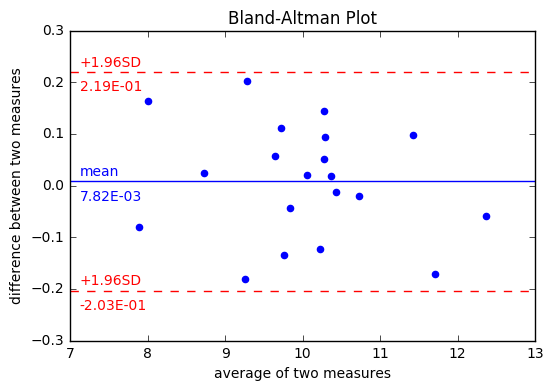

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, edgecolors="face", **kwargs)
    plt.axhline(md,           color='blue', linestyle='-')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    
    # text
    axes = plt.gca()
    mxlim = axes.get_xlim()
    mylim = axes.get_ylim()
    ywidth = mylim[1] - mylim[0]
    xwidth = mxlim[1] - mxlim[0]
    
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md + 0.02 * ywidth, 
        "mean", color="b")
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md - 0.06 * ywidth, 
        "{:.2E}".format(md), color="b")
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md + 1.96 * sd + 0.02 * ywidth, 
        "+1.96SD", color="r")
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md + 1.96 * sd - 0.06 * ywidth, 
        "{:.2E}".format(md + 1.96 * sd), color="r")
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md - 1.96 * sd + 0.02 * ywidth, 
        "+1.96SD", color="r")
    plt.text(
        mxlim[0] + 0.02 * xwidth ,
        md - 1.96 * sd - 0.06 * ywidth, 
        "{:.2E}".format(md - 1.96 * sd), color="r")
    plt.title("Bland-Altman Plot")
    plt.ylabel("difference between two measures")
    plt.xlabel("average of two measures")
    
data1 = np.random.normal(10, size=[20])
data2 = data1 + np.random.normal(0., 0.1, size=[20])
bland_altman_plot(data1, data2)

In [43]:
xlim

<function matplotlib.pyplot.xlim>

In [19]:

pd.to_datetime("today")

Timestamp('2017-10-12 00:00:00')

In [20]:
# import pybloqs.block.table_formatters as tf

In [21]:
def evaluate_based_on_note(df, note):
    # for radius_method in ["cylinder volume + sphere compensation"]:
    for radius_method in available_radius_methods:
        dfs = df[
            df[note_key] ==  note + radius_method
        ]
        dfsp = show_error(dfs, radius_method=radius_method, plotkw=plotkw)

In [22]:
# import logging
# logger = logging.getLogger()
# logging.basicConfig()
# for x in range(10):
#     logger.warning('{0}\r'.format(x))
#     print 'uu{0}\r'.format(x),
# print

# Run data

In [23]:

def run_configs(configs, loglevel=None):
    teigen_ok_fail_list = "~/teigen_ok_fail_list.csv"
    
    if loglevel is None:
        import logging
        debuglevel = logging.WARNING
    
    tg = teigen.tgmain.Teigen()
    tg.set_loglevel(loglevel)
    for i, config in enumerate(configs):
        # old failing
        # tg = teigen.tgmain.Teigen()
        # config = tg.get_default_config()
        tg.use_default_config()
        tg.update_config(**config)
        gc = config["generators"]["Unconnected tubes"]
        print (str(i) + " / " + str(len(configs)))  
        print (config["output"]["note"])
        print("rng {}, r {}, l {}, res {}".format(
            gc["random_generator_seed"], 
            gc["radius_distribution_mean"],
            gc["length_distribution_mean"],
            config["postprocessing"]["measurement_resolution"]
        ))
        rowcfg = tg.config_to_row_dataframe()
        append_dataframe_to_csv(rowcfg, teigen_ok_fail_list)
        tg.step1()
        print("step1 finished")
        tg.step2()
        remove_rows_from_csv(teigen_ok_fail_list)
        print("step2 finished")
        # del(tg)


def select_configs(all_configs, run_list):
    configs = []
    for config in all_configs:
        if config["output"][run_label_key] in run_list:
            configs.append(config)
    return configs